In [91]:
# Use seaborn for pairplot
!pip install seaborn

In [92]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [93]:
dataset_path = keras.utils.get_file("wondery4.data", "https://drive.google.com/uc?export=download&id=1l2CEyfhMaRsZJ-oizH0zvzNegiwunLcc")
dataset_path

8192/1016 [=================================================================================================================================================================================================================================================] - 0s 0us/step


'/root/.keras/datasets/wondery4.data'

Gender 1 = male <br>
Gender 2 = female

In [94]:
column_names = ['stroop','gender', 'age', 'levelsSkipped','objectsFound']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,stroop,gender,age,levelsSkipped,objectsFound
45,1.000,2,15,0,6
46,0.933,1,14,2,3
47,1.000,2,15,3,3
48,0.833,2,12,2,2
49,1.000,2,11,2,4


In [95]:
dataset.isna().sum()

stroop           0
gender           0
age              0
levelsSkipped    0
objectsFound     0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [97]:
dataset.tail()

,stroop,gender,age,levelsSkipped,objectsFound
45,1.000,2,15,0,6
46,0.933,1,14,2,3
47,1.000,2,15,3,3
48,0.833,2,12,2,2
49,1.000,2,11,2,4


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

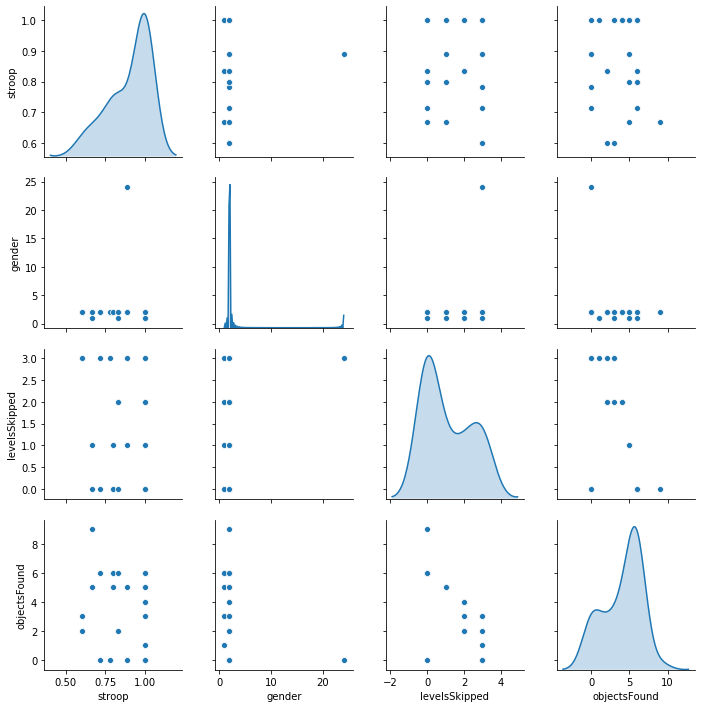

In [99]:
sns.pairplot(train_dataset[["stroop", "gender", "levelsSkipped", "objectsFound"]], diag_kind="kde")

In [100]:
train_stats = train_dataset.describe()
train_stats.pop("stroop")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
gender,40.0,2.425,3.514713,1.0,2.0,2.0,2.00,24.0
age,40.0,13.950,3.419027,2.0,12.0,14.0,15.25,21.0
levelsSkipped,40.0,1.100,1.256777,0.0,0.0,0.5,2.00,3.0
objectsFound,40.0,4.100,2.447395,0.0,2.0,5.0,6.00,9.0


In [0]:
train_labels = train_dataset.pop('stroop')
test_labels = test_dataset.pop('stroop')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [105]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [106]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.06222443],
       [-0.09769609],
       [-0.06645773],
       [-0.07420681],
       [-0.0311451 ],
       [ 0.00544011],
       [-0.01128241],
       [-0.01813035],
       [-0.13294722],
       [-0.00131136]], dtype=float32)

In [107]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [108]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.005235,0.054323,0.005235,0.045019,0.172095,0.045019,995
996,0.005282,0.056608,0.005282,0.027651,0.139619,0.027651,996
997,0.005186,0.054011,0.005186,0.043980,0.171208,0.043980,997
998,0.005149,0.055996,0.005149,0.027870,0.139572,0.027870,998
999,0.005109,0.053509,0.005109,0.043646,0.171551,0.043646,999


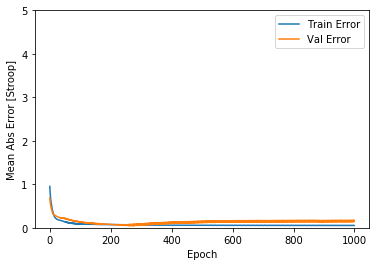

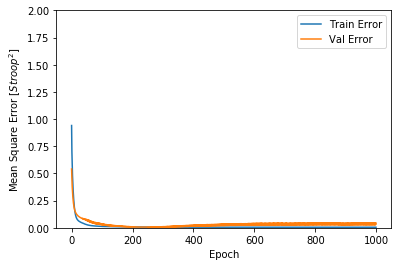

In [112]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Stroop]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Stroop^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
.......................................................................................

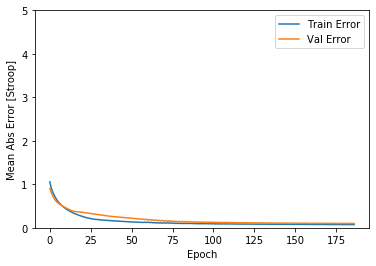

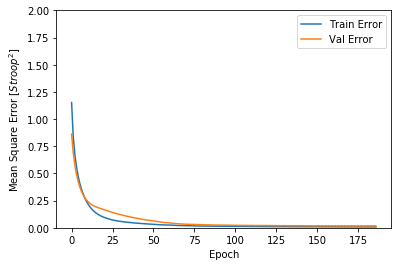

In [113]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [114]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Stroop".format(mae))

10/10 - 0s - loss: 0.0286 - mae: 0.1351 - mse: 0.0286
Testing set Mean Abs Error:  0.14 Stroop


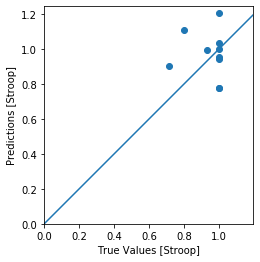

In [115]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Stroop]')
plt.ylabel('Predictions [Stroop]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 10], [0, 10])

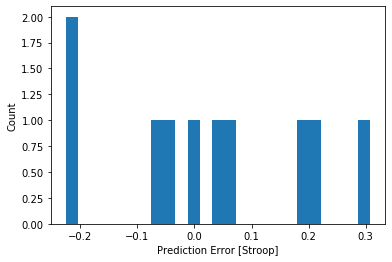

In [116]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Stroop]")
_ = plt.ylabel("Count")